In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load the dataset
df = pd.read_csv('/content/War_Sentimetal_data.csv')

# Display basic information about the dataset
print(df.info())

# Function to preprocess text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into text
    return ' '.join(tokens)

# Apply preprocessing to the 'tweet' column
df['clean_tweet'] = df['tweet'].apply(preprocess_text)

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis
df['sentiment_score'] = df['clean_tweet'].apply(get_sentiment_score)

# Classify sentiment into categories
def get_sentiment_category(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10014 non-null  int64  
 1   conversation_id  10014 non-null  int64  
 2   created_at       10014 non-null  object 
 3   date             10014 non-null  object 
 4   time             10014 non-null  object 
 5   timezone         10014 non-null  int64  
 6   user_id          10014 non-null  int64  
 7   username         10014 non-null  object 
 8   name             10014 non-null  object 
 9   place            3 non-null      object 
 10  tweet            10014 non-null  object 
 11  language         10014 non-null  object 
 12  mentions         10014 non-null  object 
 13  urls             10014 non-null  object 
 14  photos           10014 non-null  object 
 15  replies_count    10014 non-null  int64  
 16  retweets_count   10014 non-null  int64  
 17  likes_count 

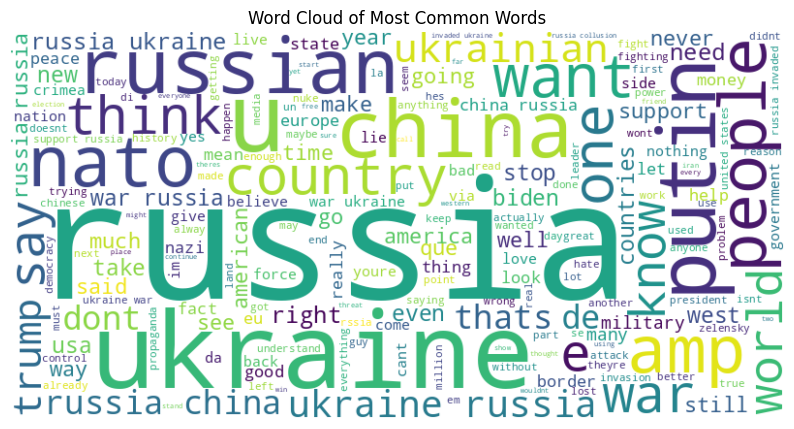

In [ ]:
# Combine all tweets into a single text for word cloud
all_tweets = ' '.join(df['clean_tweet'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()


In [ ]:
import plotly.graph_objects as go

# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Average sentiment score over time
sentiment_over_time = df.groupby(df['date'].dt.date)['sentiment_score'].mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=sentiment_over_time['date'], y=sentiment_over_time['sentiment_score'],
                    mode='lines+markers',
                    name='Average Sentiment Score'))
fig.update_layout(title='Average Sentiment Score Over Time',
                  xaxis_title='Date',
                  yaxis_title='Average Sentiment Score')
fig.show()


In [ ]:
language_counts = df['language'].value_counts().reset_index()
language_counts.columns = ['Language', 'Count']

fig = px.bar(language_counts, x='Language', y='Count',
             labels={'x': 'Language', 'y': 'Count'},
             title='Distribution of Tweets by Language')
fig.show()


In [ ]:
from collections import Counter

# Extract hashtags from tweets
def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return hashtags

df['hashtags'] = df['tweet'].apply(extract_hashtags)

# Flatten list of hashtags
all_hashtags = [item for sublist in df['hashtags'] for item in sublist]

# Count occurrences of each hashtag
top_hashtags = Counter(all_hashtags).most_common(10)

# Prepare data for visualization
hashtags, counts = zip(*top_hashtags)

fig = px.bar(x=hashtags, y=counts,
             labels={'x': 'Hashtag', 'y': 'Count'},
             title='Top 10 Hashtags Used in Tweets')
fig.show()


In [ ]:
fig = px.scatter(df, x='retweets_count', y='likes_count',
                 color='sentiment_category',
                 hover_data=['tweet'],
                 labels={'retweets_count': 'Retweets', 'likes_count': 'Likes'},
                 title='Scatter Plot of Retweets vs Likes')
fig.show()


In [ ]:
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Average sentiment score over time
sentiment_over_time = df.groupby(df['date'].dt.date)['sentiment_score'].mean().reset_index()

# Plot average sentiment score over time
fig = go.Figure()
fig.add_trace(go.Scatter(x=sentiment_over_time['date'], y=sentiment_over_time['sentiment_score'],
                    mode='lines+markers',
                    name='Average Sentiment Score'))
fig.update_layout(title='Average Sentiment Score Over Time',
                  xaxis_title='Date',
                  yaxis_title='Average Sentiment Score')
fig.show()



In [ ]:
import plotly.figure_factory as ff

# Histogram of sentiment scores
fig = ff.create_distplot([df['sentiment_score']], group_labels=['Sentiment Score'], bin_size=0.1)
fig.update_layout(title='Distribution of Sentiment Scores', xaxis_title='Sentiment Score', yaxis_title='Density')
fig.show()
